In [1]:
import numpy as np
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.constants as constants

import sys
import os
dir_current = globals()['_dh'][0]
dir_repo = dir_current+'/../..'
dir_BinnedFit = dir_repo+"/BinnedFit"
dir_KLens = dir_repo+"/KLens"


sys.path.append(dir_BinnedFit)
from gen_mocks import gen_mock_tfCube
from RotationCurveFit import RotationCurveFit, GaussFit_signle
from ChainTool import ChainTool
from Gamma import Gamma

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

# set parameters

In [2]:
###### set up parameters ######

line_species='Halpha'

pars = {}
pars['g1'] = 0.05
pars['g2'] = 0.05
pars['sini'] = 0.5

pars['redshift'] = 0.4

pars['aspect'] = 0.2
pars['r_hl_image'] = 0.5
pars['r_hl_spec'] = 0.5

pars['theta_int'] = 0. #np.pi/3.

pars['slitWidth'] = 0.12
pars['ngrid'] = 128

pars['norm'] = 0.0

pars['Resolution'] = 5000.
pars['expTime'] = 60.*30. #60.*30.
pars['pixScale'] = 0.1185
pars['nm_per_pixel'] = 0.033
pars['throughput'] = 0.29
pars['psfFWHM'] = 0.5

pars['area'] = 3.14 * (1000./2.)**2 

pars['vcirc'] = 200.

linelist = np.empty(5,dtype=[('species',np.str_,16),
                                  ('lambda',np.float),
                                  ('flux',np.float)])
linelist['species'] = ['OIIa','OIIb','OIIIa','OIIIb','Halpha']
linelist['lambda'] =  [372.7092,372.9875,496.0295,500.8240,656.461]

fiber_SDSS = np.pi * 1.5**2
refSDSSspec = 3.*1e-17 * u.erg/u.second/u.Angstrom/u.cm**2
refSDSSspec = refSDSSspec.to(u.erg/u.second/u.nm/u.cm**2)

linelist['flux'] = refSDSSspec.value / fiber_SDSS  # [unit: erg/s/cm2/nm/arcsec2]

pars['linelist'] = linelist

In [3]:
dataInfo = gen_mock_tfCube(pars, line_species, noise_mode=0)

In [4]:
thresholdSNR = 1e-6
is_weightSNR=0

GM=Gamma(data_info=dataInfo, \
         active_par_key=['vcirc', 'sini', 'vscale', 'r_0', 'v_0', 'g1', 'g2', 'r_hl_image', 'theta_int', 'flux'], \
         thresholdSNR = thresholdSNR, is_weightSNR=is_weightSNR)

time cost in gaussFit_spec2D: 0.056819915771484375 (secs)
time cost in gaussFit_spec2D: 0.08539915084838867 (secs)


In [5]:
print(GM.RotFit.spec[0].array.shape)
print(GM.RotFit.spec[1].array.shape)

(104, 122)
(128, 122)


In [6]:
active_par_fid = np.zeros(len(GM.active_par_key))
for j, item in enumerate(GM.active_par_key):
    active_par_fid[j] = GM.par_fid[item]
active_par_fid

array([2.00000000e+02, 5.00000000e-01, 5.00000000e-01, 0.00000000e+00,
       0.00000000e+00, 5.00000000e-02, 5.00000000e-02, 5.00000000e-01,
       0.00000000e+00, 5.23723984e+02])

# Check

In [14]:
active_par_in = active_par_fid.copy()
#active_par_in = np.array([ 1.99225356e+02,  2.98954781e-01,  1.10562723e-01,  6.56244213e-02,
#        1.24504832e+00,  9.41966041e-02,  6.14681631e-02,  5.03369134e-01,
#       -1.88219550e-01,  5.27130697e+02,  5.95593726e+01])
par_in = GM.Pars.gen_par_dict(active_par=active_par_in, active_par_key=GM.active_par_key, par_ref=GM.par_base)

In [15]:
for ind, key in enumerate(GM.active_par_key):
    print(key+": ",active_par_in[ind])

vcirc:  200.0
sini:  0.5
vscale:  0.5
r_0:  0.0
v_0:  0.0
g1:  0.05
g2:  0.05
r_hl_image:  0.5
theta_int:  0.0
flux:  523.7239837646484


### likelihood

In [22]:
par = GM.Pars.gen_par_dict(active_par=active_par_in, active_par_key=GM.active_par_key, par_ref=GM.par_base)
active_par_ImgFit = [par[item_key] for item_key in GM.active_par_key_img]
loglike_image = GM.ImgFit.cal_loglike(active_par=active_par_ImgFit)
loglike_image

-0.0

In [23]:
logL_spec = GM.RotFit.cal_loglike(active_par=active_par_in)
logL_spec

-117.80939126883374

In [16]:
loglike_now = GM.cal_loglike(active_par=active_par_in)
loglike_now

-117.80939126883374

In [17]:
image_out = GM.ImgFit.model_image(sini=par_in['sini'] , half_light_radius=par_in['r_hl_image'], \
                                  theta_int=par_in['theta_int'], g1=par_in['g1'], g2=par_in['g2'])

In [18]:
rot_curve_out = []
for j in range(GM.RotFit.Nspec):
    print(f'specID {j}: {len(GM.RotFit.spec[j].spaceGrid)} elemnets')
    rot_curve_j = GM.RotFit.model_arctan_rotation(r=GM.RotFit.spec[j].spaceGrid, \
                                                vcirc = par_in['vcirc'], \
                                                sini = par_in['sini'], \
                                                vscale=par_in['vscale'], \
                                                r_0=par_in['r_0'], v_0=par_in['v_0'], \
                                                g1=par_in['g1'], g2=par_in['g2'], \
                                                theta_int=par_in['theta_int'], redshift=par_in['redshift'], \
                                                slitAngle=par_in['slitAngles'][j]
                                               )
    rot_curve_out.append(rot_curve_j)

specID 0: 104 elemnets
specID 1: 128 elemnets


## Image display

Text(0.5, 1.0, 'model at par_in')

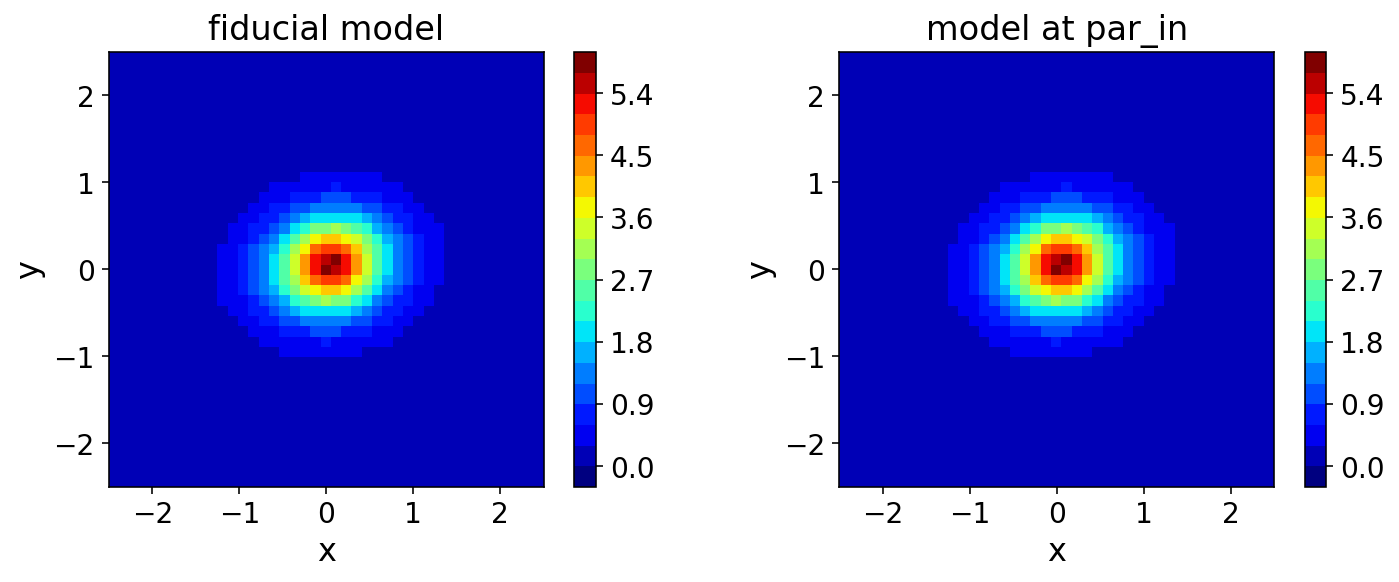

In [19]:
obsImg = dataInfo['image']

X, Y = np.meshgrid(dataInfo['spaceGrid'], dataInfo['spaceGrid'])

fig, ax = plt.subplots(1,2, figsize=(12., 4.))
plt.rc('font',size=14)

levels = MaxNLocator(nbins=20).tick_values(obsImg.min(), obsImg.max())
norm = BoundaryNorm(levels, ncolors=plt.cm.jet.N, clip=True)

galo = ax[0].pcolormesh(X, Y, dataInfo['image'], cmap=plt.cm.jet, norm=norm)
galm = ax[1].pcolormesh(X, Y, image_out, cmap=plt.cm.jet, norm=norm)

fig.colorbar(galo, ax=ax[0])
fig.colorbar(galm, ax=ax[1])

axixlim = 2.5

for j in range(2):
    ax[j].set_xlim((-axixlim, axixlim))
    ax[j].set_ylim((-axixlim, axixlim))
    ax[j].set_aspect('equal')
    ax[j].set_xlabel('x', fontsize=16)
    ax[j].set_ylabel('y', fontsize=16)

ax[0].set_title('fiducial model')
ax[1].set_title('model at par_in')

## spec display

time cost in gaussFit_spec2D: 0.06726717948913574 (secs)
time cost in gaussFit_spec2D: 0.08212924003601074 (secs)


Text(0.5, 0.98, 'g1=0.05 | g2=0.05 | sini=0.5')

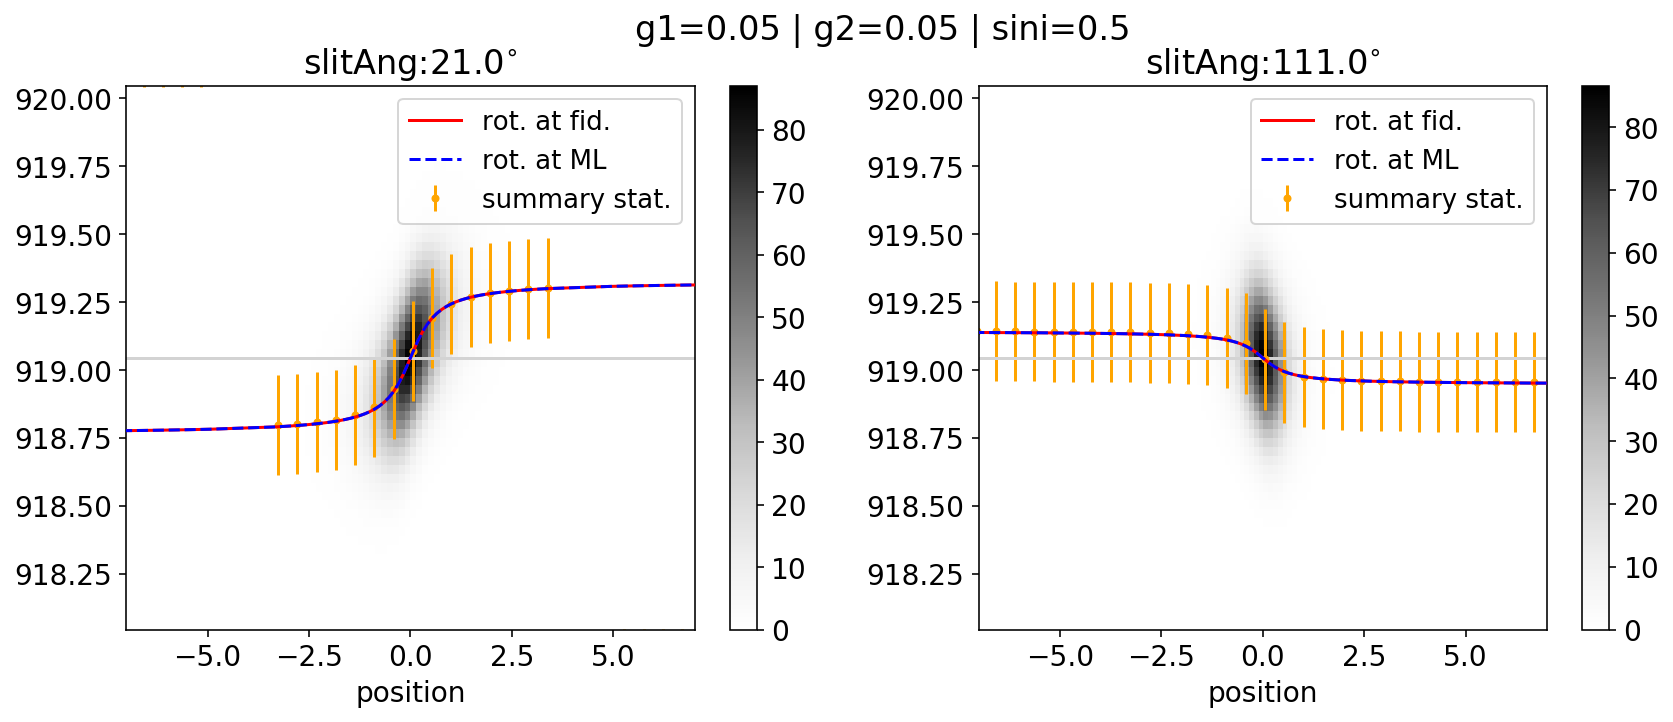

In [20]:

# # get pixel edges


lambda0 = dataInfo['lambda0']

############

fig,ax = plt.subplots(1,2,figsize=(14,5))
plt.rc('font',size=14)

# broad pixel edges
lambdaGrid0, spaceGrid0 = dataInfo['spec'][0].lambdaGrid, dataInfo['spec'][0].spaceGrid
lambda_min = np.min(lambdaGrid0)  ; lambda_MAX = np.max(lambdaGrid0)
x_min = np.min(spaceGrid0)        ; x_MAX = np.max(spaceGrid0)


img0=ax[0].imshow(dataInfo['spec'][0].array.T, extent=[x_min, x_MAX, lambda_min, lambda_MAX ], aspect='auto',cmap='Greys', origin="lower")
img1=ax[1].imshow(dataInfo['spec'][1].array.T, extent=[x_min, x_MAX, lambda_min, lambda_MAX ], aspect='auto',cmap='Greys', origin="lower")
fig.colorbar(img0, ax=ax[0])
fig.colorbar(img1, ax=ax[1])

## measured summary statstics

for IDsp in range(2):
    GaussFit = GaussFit_signle(spec2D=GM.RotFit.spec[IDsp], lambda0=lambda0, thresholdSNR=thresholdSNR)
    peakLambda, amp, sigma = GaussFit.gaussFit_spec2D()
    jump = 4
    ax[IDsp].errorbar(GaussFit.spec2D.spaceGrid[0::jump], peakLambda[0::jump], sigma[0::jump] ,color='orange', marker='o', markersize=3,ls='none',label='summary stat.')
############

## fiducial rotation curve

for IDsp in range(2):
    fidicual_rot = GM.RotFit.model_arctan_rotation(r=GM.RotFit.spec[IDsp].spaceGrid, \
                                                   vcirc=GM.par_fid['vcirc'], sini=GM.par_fid['sini'], \
                                                   vscale=GM.par_fid['vscale'], r_0=GM.par_fid['r_0'], v_0=GM.par_fid['v_0'], \
                                                   g1=GM.par_fid['g1'], g2=GM.par_fid['g2'], \
                                                   theta_int=GM.par_fid['theta_int'], redshift=GM.par_fid['redshift'], \
                                                   slitAngle=GM.par_fid['slitAngles'][IDsp])
    
    ax[IDsp].plot(GM.RotFit.spec[IDsp].spaceGrid,fidicual_rot,color='r',ls='-',label='rot. at fid.', zorder=10)

#ax[0].plot(GM.RotFit.spec_stats[0]['spaceGrid'],model_major,color='b',ls=':',label='fiducial rot.', zorder=10)
#ax[1].plot(GM.RotFit.spec_stats[1]['spaceGrid'],model_minor,color='b',ls=':',label='fiducial rot.', zorder=10)    


## par_in rotation curve

for IDsp in range(2):
    ax[IDsp].plot(GM.RotFit.spec[IDsp].spaceGrid, rot_curve_out[IDsp],color='b',ls='--',label='rot. at ML', zorder=10)
    

###############

lambda_cen = dataInfo['lambda0']*(1.+dataInfo['par_fid']['redshift'])

for j in range(2):
    ax[j].axhline(lambda_cen, color='lightgray')
    ax[j].set_xlabel('position', fontsize=14)
    
    x_width=7
    ax[j].set_xlim(-x_width,x_width)
    
    y_width=1
    ax[j].set_ylim(lambda_cen-y_width,lambda_cen+y_width)
    
    slitAng_i = pars['slitAngles'][j]*180./np.pi
    ax[j].set_title( f'slitAng:{slitAng_i:.1f}'+'$^{\circ}$' )
    
    ax[j].legend(loc="best",prop={'size':13})


g1=pars['g1']
g2=pars['g2']
sini=pars['sini']

fig.suptitle(f'g1={g1:.2f} | g2={g2:.2f} | sini={sini:.1f}')

# =========== END ===========